In [164]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

random.seed(0)

print("Running...")


thr_std=0.2

E = Events("CheatedRecoFile_1.root")

view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")

u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x

v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x



Running...


In [165]:
print(len(u_x))

9310


In [202]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

In [203]:
def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


In [204]:
def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x

In [205]:
def line_finder(point1, point2):
    slope = (point1[1] - point2[1])/(point1[0] - point2[0])
    intercept = point1[1] - slope * point1[0]
    return slope, intercept

In [206]:
def line_intersect(slope1, intercept1, slope2, intercept2):
    x_point = (intercept2 - intercept1)/(slope1 - slope2)
    y_point = slope1 * x_point + intercept1
    return x_point, y_point

In [238]:
def select_random_points(AoI_x, AoI_z, AoI_adc, iterations, no_std=thr_std):
    initial_vertex_points = np.empty((iterations, 2))
    vertex_length = len(AoI_x)
    if vertex_length > 4:
        range_x = (np.amin(AoI_x), np.amax(AoI_x))
        range_z = (np.amin(AoI_z), np.amax(AoI_z))
        for i in range(iterations):
            sample = random.sample(range(0, vertex_length), 4)
            vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
            point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
            slope1, intercept1 = line_finder(point1, point2)
            slope2, intercept2 = line_finder(point3, point4)
            x_point, y_point = line_intersect(slope1, intercept1, slope2, intercept2)
            if x_point > range_x[0] and x_point < range_x[1] and y_point > range_z[0] and y_point < range_z[1]:
                initial_vertex_points[i, 0], initial_vertex_points[i, 1] = x_point, y_point

    return initial_vertex_points

In [251]:
def plotter_4_line(plane, event_number, thresholding=True, no_std=thr_std, iterations=1000):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    vertex_points = select_random_points(AoI_x, AoI_z, AoI_adc, iterations)
    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.scatter(vertex_points[:,1], vertex_points[:,0], color="red")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0

In [252]:
def heatmap4points(plane, event_number, thresholding=True, no_std=thr_std, iterations=10000, binwdith=100):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    vertex_points = select_random_points(AoI_x, AoI_z, AoI_adc, iterations)
    
    histvertex = plt.hist2d(vertex_points[:,1], vertex_points[:,0], bins=(binwdith, binwdith), cmap=plt.cm.jet)
    
    histogram_array = histvertex[0]
    max_value = np.amax(histogram_array)
    indices = np.where(histogram_array == max_value)
    #print("Indices: ", indices)
    z_value = histvertex[1][indices[0]]
    x_value = histvertex[2][indices[1]]
    #print("Z_value: ", z_value)
    #print("X_value: ", x_value)

    return z_value[0], x_value[0]

(60.5256494140625, 86.81226928710936)


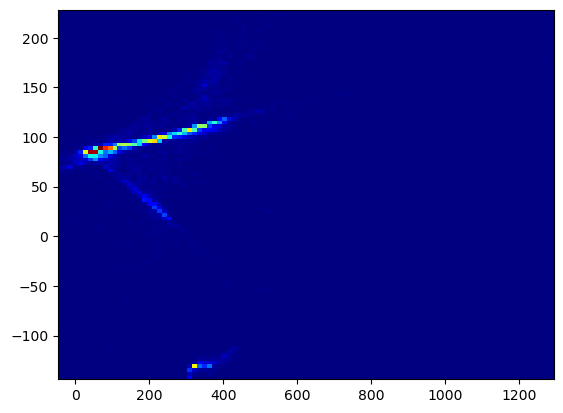

In [253]:
print(heatmap4points("u", 141))

In [256]:
def accuracy(plane, function, no_events, thresholding=False, no_std=thr_std, ifrandom=True):
    Zvert = [None] * no_events
    Zvert_true = [None] * no_events
    Xvert = [None] * no_events
    Xvert_true = [None] * no_events #avoid appends to lists; if you know how long the outputs are going to be, then assign the arrays to
                    #that length beforehand
    if ifrandom:
        for i in tqdm(range(no_events)):   
            j = random.randint(0, len(u_x))
            AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, j, thresholding, no_std)
            Zvert_place, Xvert_place = function(plane, j)[0], function(plane, j)[1]
            Zvert[i] = Zvert_place
            Xvert[i] = Xvert_place
            Zvert_true[i] = Zvert_true_place
            Xvert_true[i] = Xvert_true_place
    else:
        for i in tqdm(range(no_events)):
            AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, i, thresholding, no_std)
            Zvert_place, Xvert_place = function(plane, i)[0], function(plane, i)[1]
            Zvert[i] = Zvert_place
            Xvert[i] = Xvert_place
            Zvert_true[i] = Zvert_true_place
            Xvert_true[i] = Xvert_true_place
    
    
    #print("Zverttrue: ", Zvert_true)
    #print("Zvert: ", Zvert)
    #print("Xvert_true: ",Xvert_true)
    #print("Xvert", Xvert)
    
    
    delta_z = np.array(Zvert_true) - np.array(Zvert)
    delta_x = np.array(Xvert_true) - np.array(Xvert)
    delta_r2 = delta_z**2 + delta_x**2

    #print(len(delta_r2))
    delta_r2 = [item for item in delta_r2 if item != np.inf]
    
    #data, bins = np.histogram(delta_r2)
    #delta_r2 = delta_r2[delta_r2 < 0.4e6]
    delta_r2 = np.sqrt(delta_r2)
    plt.hist(delta_r2, bins='auto')
    #plt.ylim(0, 400)
    plt.show()

    return delta_r2, np.percentile(delta_r2, 68)

  0%|                                                                                 | 1/1000 [00:00<02:44,  6.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_23576\1175323999.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_23576\1175323999.py:3: RuntimeWarning: invalid value encountered in float_scalars
  y_point = slope1 * x_point + intercept1
  1%|▉                                                                               | 12/1000 [00:02<02:50,  5.78it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_23576\1175323999.py:2: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.70it/s]


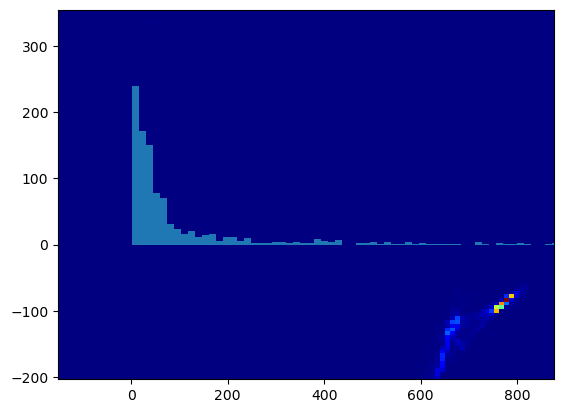

Percentile:  64.67451009645997


In [257]:
data1, data2 = accuracy("u", heatmap4points, 1000)
print("Percentile: ", data2)